In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import math 
import astropy
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import matplotlib.colors as colors


from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [3]:
#SciServer Modules
import SciServer
from SciServer import CasJobs

In [4]:
#Query of fluxes for different emission lines
EmLFQry= """select drp.MaNGAid, drp.objRA, drp.objDEC, drp.z, 
drp.nsa_elpetro_absmag_r as rMAG, 
drp.nsa_elpetro_absmag_g as gMAG, 
drp.nsa_elpetro_mass as GalMass, 

dap.emline_sflux_cen_oiii_5008 as OIII,  
dap.emline_sflux_cen_hb_4862 as HB, 
dap.emline_sflux_cen_nii_6585 as NII, 
emline_sflux_cen_ha_6564 as Ha, 

dap.daptype
from mangaDRPall as drp
JOIN mangaDAPall as dap on dap.mangaid = drp.mangaid
WHERE (drp.z < 0.15) and (drp.z > 0.001) 
and dap.daptype = 'HYB10-MILESHC-MASTARHC2'
and (5e9 < drp.nsa_elpetro_mass)
"""
           
Selection1 = CasJobs.executeQuery(EmLFQry, 'dr17')
print(Selection1)

GalMass = []
for i in range(len(Selection1['GalMass'])):
    GalMass.append([Selection1['GalMass'][i]])

       MaNGAid       objRA     objDEC         z     rMAG     gMAG  \
0     1-382273  118.634242  16.809729  0.046091 -21.9212 -21.3022   
1     1-382697  119.207582  17.380303  0.036405 -20.2943 -19.5755   
2     1-351890  121.230108  52.070824  0.069708 -21.4352 -20.8664   
3     1-351913  121.839452  51.915686  0.083180 -21.6145 -20.8405   
4     1-352063  124.546179  52.452434  0.138558 -22.2171 -21.5311   
...        ...         ...        ...       ...      ...      ...   
7191  1-245733  216.089542  52.124384  0.044429 -19.6016 -18.7485   
7192  1-246570  224.941125  49.503928  0.026638 -20.2533 -19.5915   
7193  1-246270  223.139812  50.922837  0.131037 -22.1669 -21.4540   
7194  1-457771  201.193944  26.738419  0.023360 -20.0249 -19.3195   
7195  1-403619  197.359785  28.415832  0.020648 -19.0195 -18.1873   

           GalMass        OIII         HB         NII          Ha  \
0     4.889970e+10  221.274300  81.355180  392.837000  410.203300   
1     1.750580e+10  107.564600  4

In [5]:
print('Max Mass Index: ' + str(GalMass.index(max(GalMass))))
print('Min Mass Index: ' + str(GalMass.index(min(GalMass))))

Max Mass Index: 6952
Min Mass Index: 4426


In [6]:
#Max Massive Mass
i = 2791

print('Most Massive Galaxy: \n')
print('ID: ' + str(Selection1['MaNGAid'][i]))
print('Mass: ' + str(Selection1['GalMass'][i]))
print('z: ' + str(Selection1['z'][i]))
print('OIII: ' + str(Selection1['OIII'][i]))
print('HB: ' + str(Selection1['HB'][i]))
print('NII: ' + str(Selection1['NII'][i]))
print('Ha: ' + str(Selection1['Ha'][i]) + '\n')
print('\n')

#Mass Massive Mass
i = 7158

print('Least Massive Galaxy: \n')
print('ID: ' + str(Selection1['MaNGAid'][i]))
print('Mass: ' + str(Selection1['GalMass'][i]))
print('z: ' + str(Selection1['z'][i]))
print('OIII: ' + str(Selection1['OIII'][i]))
print('HB: ' + str(Selection1['HB'][i]))
print('NII: ' + str(Selection1['NII'][i]))
print('Ha: ' + str(Selection1['Ha'][i]))

Most Massive Galaxy: 

ID: 1-261008
Mass: 86244300000.0
z: 0.0650357
OIII: 23.09921
HB: -2.889
NII: 41.67047
Ha: 12.03978



Least Massive Galaxy: 

ID: 1-71869
Mass: 39544900000.0
z: 0.040093
OIII: 53.7986
HB: 13.5
NII: 49.75811
Ha: 39.45697


In [7]:
 #Omitting NaN values from the raw data
BPTX = abs(Selection1['NII']/Selection1['Ha'])
BPTY = abs(Selection1['OIII']/Selection1['HB'])
ID = Selection1['MaNGAid']

BPTX = BPTX.dropna()
BPTY = BPTY.dropna()

BPTX = list(filter(None, BPTX))
BPTY = list(filter(None, BPTY))

print (len(BPTX))
print (len(BPTY))

7193
7193


In [8]:
#Separating the data based on the equations provided by Kauffman and Trou
agnBPTx = []
agnBPTy = []

sfBPTx = []
sfBPTy = []

gBPTx = []
gBPTy = []

#MaNGA ID Lists
AGN_ID = []

SF_ID = []

MaNGAID = Selection1['MaNGAid']

for i in range(len(BPTX)):
    if (BPTY[i] > ((-0.61 * (np.log(BPTX[i]) - 0.05)) + 1.3)) and (BPTY[i] > ((-1.2 * np.log(BPTX[i])) - 0.4)):
        agnBPTx.append(BPTX[i])
        agnBPTy.append(BPTY[i])
        AGN_ID.append(ID[i])
    elif (BPTY[i] < (-1.2 * np.log(BPTX[i])) - 0.4) and (BPTY[i] < ((-0.61 * (np.log(BPTX[i]) - 0.05)) + 1.3)):
        sfBPTx.append(BPTX[i])
        sfBPTy.append(BPTY[i])
        SF_ID.append(ID[i])
    elif (((BPTY[i] > (-1.2 * np.log(BPTX[i])) - 0.4) and (BPTY[i] < (-0.61 * (np.log(BPTX[i]) - 0.05) + 1.3 ))) or ((BPTY[i] < ((-0.61 * (np.log(BPTX[i]) - 0.05)) + 1.3)) and (BPTY[i] > (-1.2 * np.log(BPTX[i])) - 0.4))):
        gBPTx.append(BPTX[i])
        gBPTy.append(BPTY[i])
    else:
        print(str(BPTX[i]) + ', ' + str(BPTY[i]) + ': Index = ' + str(i))
        print('Something is broken :( \n')

        
print('Current Index: ' + str(i))
print(str(MaNGAID[i]) + '\n')

print('AGN Galaxies: ' + str(len(agnBPTx)))
print('Star Forming Galaxies: ' + str(len(sfBPTx)))
print('Grey Galaxies: ' + str(len(gBPTx)) + '\n')

print('AGN x: ' + str(agnBPTx))
print('AGN y: ' + str(agnBPTy) + '\n')

print('Star Forming x:' + str(sfBPTx))
print('Star Forming y:' + str(sfBPTy) + '\n')

print('Grey Galaxies x:' + str(gBPTx))
print('Grey Galaxies y:' + str(gBPTy) + '\n') 


0.013441931647915496, 4.447745503753831: Index = 2934
Something is broken :( 

Current Index: 7192
1-246570

AGN Galaxies: 4312
Star Forming Galaxies: 1466
Grey Galaxies: 1414

AGN x: [0.9576641631113157, 0.681963112659854, 11.36405875655764, 1.568441567833252, 0.6995226151330501, 1.2673048653077656, 1.9184214017160879, 0.44364664110281443, 1.0308255176657921, 0.8800072067501072, 0.5783234336205706, 1.311691899452068, 3.3966775333861214, 1.4792838078445292, 2.1483226085788085, 0.7687855770871527, 2.379380844687499, 1.8526473331052327, 0.9003430147869501, 0.8219086766080813, 4.1612898153891384, 1.6116603118185766, 2.6735317509033942, 1.4695996104224474, 1.5235250559931741, 1.5064015697265711, 1.9874590991591314, 8.715885919254537, 1.5741887567376138, 1.5228767251727509, 4.842050849564328, 2.636126780098503, 1.9229547984667874, 1.0122557546580906, 0.6451351561376214, 0.9983539155692187, 2.0172923131003806, 0.7708857636620862, 0.7921567149674138, 1.5800338221764005, 10.245609478670515, 0.

In [9]:
#Creating Excel file for MaNGA IDs
from openpyxl import Workbook
import xlsxwriter

#AGN IDs
AGNExcel = pd.DataFrame({"MaNGA IDs: AGN": AGN_ID})
AGNExcel.to_excel("Massive_AGN_ID.xlsx", index=False)

#Star Forming IDs
SFExcel = pd.DataFrame({"MaNGA IDs: Star Forming": SF_ID})
SFExcel.to_excel("Massive_SF_ID.xlsx", index=False)

In [10]:
#Equations separating star forming and AGN populations
#Kaufmann et al. 2003
AGN = (-0.61 * (np.log(BPTX) - 0.05)) + 1.3
#Trouille et al. 2011
SF = (-1.2 * np.log(BPTX)) - 0.4

In [11]:
#Correcting order for pop separated lines
AGN_Line = np.array(list(zip(BPTX, AGN)))
AGN_Line = sorted(AGN_Line, key=lambda x: x[0])

SF_Line = np.array(list(zip(BPTX, SF)))
SF_Line = sorted(SF_Line, key=lambda x: x[0])

In [12]:
#Splitting elements back into two lists
BPTX_plt = []
AGN_plt = []
SF_plt = []

for i in range(len(AGN_Line)):
    BPTX_plt.append([AGN_Line[i][0]])
    AGN_plt.append([AGN_Line[i][1]])

for i in range(len(SF_Line)):
    SF_plt.append([SF_Line[i][1]])

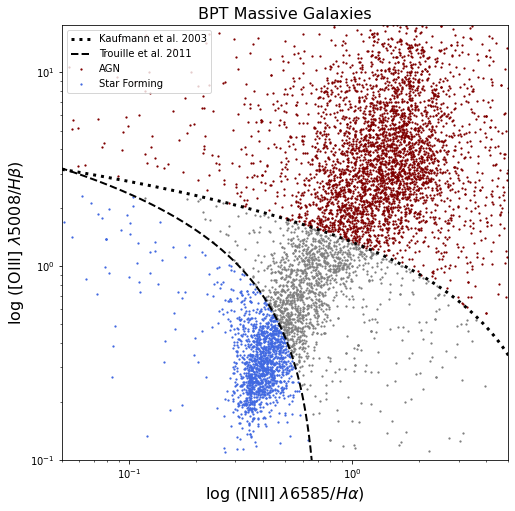

In [13]:
plt.figure(figsize = (8, 8))
plt.title('BPT Massive Galaxies', fontsize = 16)

#AGN
plt.scatter(agnBPTx, agnBPTy, color = 'maroon', alpha = 1, s = 1.5, label = "AGN")
#SF
plt.scatter(sfBPTx, sfBPTy, color = 'royalblue', alpha = 1, s = 1.5, label = "Star Forming")
#Grey
plt.scatter(gBPTx, gBPTy, color = 'grey', alpha = 1, s = 1.5)


plt.ylabel('log ([OIII] ${\u03BB}$5008/$H{\u03B2}$)', fontsize = 16)
plt.xlabel('log ([NII] ${\u03BB}$6585/$H{\u03B1}$)', fontsize = 16)
plt.xscale('log')
plt.yscale('log')
plt.xlim(.5e-1, 0.5e1)
plt.ylim(1e-1, 1.75e1)

plt.plot(BPTX_plt, AGN_plt, color = 'black', linestyle = ':', linewidth = 3, label = "Kaufmann et al. 2003")
plt.plot(BPTX_plt, SF_plt, color = 'black', linestyle = '--', linewidth = 2, label = "Trouille et al. 2011")
legend = plt.legend(loc = 'upper left')

plt.savefig('Massive Galaxy BPT Diagram', dpi = 600, bbox_inches = 'tight')
plt.show()